# Task 4

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

sns.set(style="whitegrid")

In [11]:
df = pd.read_csv('../data/processed/cleaned_data.csv', index_col='Date', parse_dates=True)

# Assets
assets = ['TSLA', 'BND', 'SPY']

# Drop missing values if any
df = df[assets].dropna()

In [12]:
forecasted_prices = pd.read_csv('../data/processed/tsla_lstm_forecast.csv', index_col='Date', parse_dates=True)
tsla_forecast_returns = forecasted_prices['Forecast'].pct_change().dropna()
expected_tsla_return_daily = tsla_forecast_returns.mean()
expected_tsla_return_annual = ((1 + expected_tsla_return_daily) ** 252) - 1

# 2b. BND & SPY: Use historical daily returns (annualized)
returns = df.pct_change().dropna()
expected_returns = {
    'TSLA': expected_tsla_return_annual,
    'BND': ((1 + returns['BND'].mean()) ** 252) - 1,
    'SPY': ((1 + returns['SPY'].mean()) ** 252) - 1
}

expected_returns = pd.Series(expected_returns)
print("Expected Annual Returns:")
display(expected_returns)

Expected Annual Returns:


TSLA    0.095617
BND     0.014186
SPY     0.146826
dtype: float64


Covariance Matrix (Annualized):


,TSLA,BND,SPY
TSLA,0.327006,0.001743,0.046944
BND,0.001743,0.002961,0.001046
SPY,0.046944,0.001046,0.031002


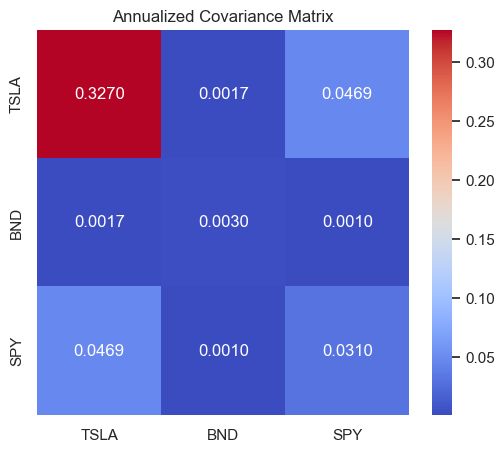

In [13]:
cov_matrix = returns.cov() * 252  # Annualized
print("\nCovariance Matrix (Annualized):")
display(cov_matrix)

# Heatmap for covariance
plt.figure(figsize=(6, 5))
sns.heatmap(cov_matrix, annot=True, fmt=".4f", cmap="coolwarm")
plt.title("Annualized Covariance Matrix")
plt.show()

In [14]:
ef = EfficientFrontier(expected_returns, cov_matrix)
# Maximum Sharpe Ratio Portfolio
ef.max_sharpe()
sharpe_weights = ef.clean_weights()
sharpe_perf = ef.portfolio_performance(verbose=True)

# Minimum Volatility Portfolio
ef_minvol = EfficientFrontier(expected_returns, cov_matrix)
ef_minvol.min_volatility()
minvol_weights = ef_minvol.clean_weights()
minvol_perf = ef_minvol.portfolio_performance(verbose=True)

Expected annual return: 9.3%
Annual volatility: 10.9%
Sharpe Ratio: 0.85
Expected annual return: 2.2%
Annual volatility: 5.3%
Sharpe Ratio: 0.42


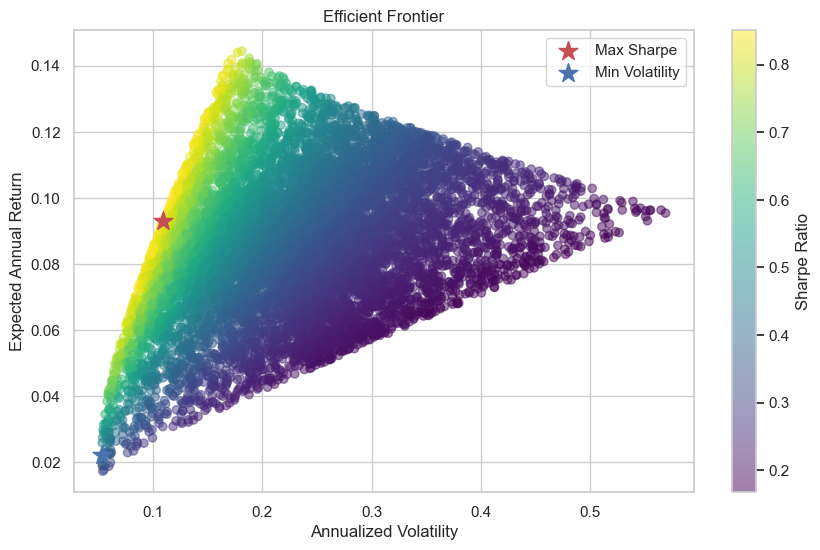

In [15]:
n_portfolios = 10000
results = np.zeros((3, n_portfolios))  # returns, volatility, sharpe

for i in range(n_portfolios):
    weights = np.random.random(len(assets))
    weights /= np.sum(weights)
    port_return = np.dot(weights, expected_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = port_return / port_vol
    results[0,i] = port_return
    results[1,i] = port_vol
    results[2,i] = sharpe

plt.figure(figsize=(10, 6))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(sharpe_perf[1], sharpe_perf[0], marker='*', color='r', s=200, label='Max Sharpe')
plt.scatter(minvol_perf[1], minvol_perf[0], marker='*', color='b', s=200, label='Min Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Expected Annual Return')
plt.title('Efficient Frontier')
plt.legend()
plt.show()


In [16]:
latest_prices = get_latest_prices(df)
da = DiscreteAllocation(sharpe_weights, latest_prices, total_portfolio_value=100000)
allocation, leftover = da.lp_portfolio()
print("\nDiscrete Allocation for $100,000 Portfolio:")
print(allocation)
print("Funds Remaining: ${:.2f}".format(leftover))


Discrete Allocation for $100,000 Portfolio:
{'BND': 592, 'SPY': 103}
Funds Remaining: $174.11


In [17]:
print("\nOptimal Portfolio Recommendation (Max Sharpe):")
print(sharpe_weights)
print("Expected Annual Return: {:.2%}".format(sharpe_perf[0]))
print("Expected Annual Volatility: {:.2%}".format(sharpe_perf[1]))
print("Sharpe Ratio: {:.2f}".format(sharpe_perf[2]))

print("\nMinimum Volatility Portfolio:")
print(minvol_weights)
print("Expected Annual Return: {:.2%}".format(minvol_perf[0]))
print("Expected Annual Volatility: {:.2%}".format(minvol_perf[1]))
print("Sharpe Ratio: {:.2f}".format(minvol_perf[2]))


Optimal Portfolio Recommendation (Max Sharpe):
OrderedDict([('TSLA', 0.0), ('BND', 0.40532), ('SPY', 0.59468)])
Expected Annual Return: 9.31%
Expected Annual Volatility: 10.93%
Sharpe Ratio: 0.85

Minimum Volatility Portfolio:
OrderedDict([('TSLA', 0.0), ('BND', 0.93993), ('SPY', 0.06007)])
Expected Annual Return: 2.22%
Expected Annual Volatility: 5.33%
Sharpe Ratio: 0.42
